# モデル作成

## インポート

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Reshape

from lib.MassBankRecord import MassBankRecord

2025-03-01 13:17:44.785025: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 13:17:44.798621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740802664.814994  341746 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740802664.818043  341746 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 13:17:44.832540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## パラメータ設定

In [28]:
mz_step = 0.5
data_folder = './MassBank-data'
min_formula_count = 15
max_mz = 2000.0

seed = 2025
batch = 4096
epochs = 300
filters = 3
kernel_size = 5


## レコード読込

In [5]:
records = MassBankRecord.get_records(data_folder, mz_step)

print(len(records), ' Records.')

122746  Records.


## 集計

In [7]:
formulas = {}
for record in records:
    formulas[record.get_formula()] = formulas.get(record.get_formula(), 0) + 1

formulas

{' C10H10O3': 167,
 ' C25H47NO9': 10,
 ' C17H12O6': 18,
 ' C17H14O6': 38,
 ' C17H12O7': 23,
 ' C17H14O7': 30,
 ' C20H20N2O3': 5,
 ' C15H16O6': 25,
 ' C14H10O5': 32,
 ' C15H12O5': 175,
 ' C16H16O8': 10,
 ' C20H16O7': 6,
 ' C21H23N3O3': 5,
 ' C32H36N2O5': 26,
 ' C15H26O2': 24,
 ' C15H26O3': 12,
 ' C15H20O6': 20,
 ' C19H24O8': 5,
 ' C19H26O7': 15,
 ' C15H10O5': 357,
 ' C14H20O4': 15,
 ' C17H22O8': 22,
 ' C22H32O8': 12,
 ' C18H16O9': 15,
 ' C16H28O4': 6,
 ' C16H26O4': 5,
 ' C24H22O8': 10,
 ' C16H12O5': 224,
 ' C23H23N5O4': 5,
 ' C19H26O8': 15,
 ' C20H18ClNO6': 15,
 ' C22H23N5O2': 22,
 ' C18H12O6': 25,
 ' C8H6O5': 4,
 ' C24H34O9': 16,
 ' C20H28O3': 12,
 ' C23H32O7': 23,
 ' C27H32O8': 10,
 ' C15H22O4': 53,
 ' C15H11NO2': 28,
 ' C15H24O3': 13,
 ' C18H22O5': 54,
 ' C31H39N5O5': 14,
 ' C32H41N5O5': 19,
 ' C19H23N3O2': 14,
 ' C16H20N2O': 28,
 ' C29H35N5O5': 5,
 ' C30H37N5O5': 5,
 ' C33H35N5O5': 11,
 ' C35H39N5O4': 5,
 ' C35H39N5O5': 19,
 ' C21H30O11': 10,
 ' C17H22O7': 42,
 ' C17H24O6': 17,
 ' C

In [8]:
len(formulas)

8907

## データ前準備

In [13]:
# 15個未満の Formula は削除
filtered_records = [r for r in records if formulas[r.get_formula()] >= min_formula_count]

print(len(filtered_records), ' Filtered Records.')

96301  Filtered Records.


In [14]:
filtered_formulas = {k : v for k, v in formulas.items() if v >= min_formula_count}
filtered_formulas

{' C10H10O3': 167,
 ' C17H12O6': 18,
 ' C17H14O6': 38,
 ' C17H12O7': 23,
 ' C17H14O7': 30,
 ' C15H16O6': 25,
 ' C14H10O5': 32,
 ' C15H12O5': 175,
 ' C32H36N2O5': 26,
 ' C15H26O2': 24,
 ' C15H20O6': 20,
 ' C19H26O7': 15,
 ' C15H10O5': 357,
 ' C14H20O4': 15,
 ' C17H22O8': 22,
 ' C18H16O9': 15,
 ' C16H12O5': 224,
 ' C19H26O8': 15,
 ' C20H18ClNO6': 15,
 ' C22H23N5O2': 22,
 ' C18H12O6': 25,
 ' C24H34O9': 16,
 ' C23H32O7': 23,
 ' C15H22O4': 53,
 ' C15H11NO2': 28,
 ' C18H22O5': 54,
 ' C32H41N5O5': 19,
 ' C16H20N2O': 28,
 ' C35H39N5O5': 19,
 ' C17H22O7': 42,
 ' C17H24O6': 17,
 ' C13H14O5': 86,
 ' C34H59NO14': 48,
 ' C15H20O7': 15,
 ' C18H22N2O2': 50,
 ' C30H22O10': 17,
 ' C45H57N3O9': 30,
 ' C29H36O10': 16,
 ' C52H70N2O11': 17,
 ' C15H22O6': 18,
 ' C22H30N4O4': 17,
 ' C10H15NO3': 17,
 ' C18H26O5': 45,
 ' C7H6O4': 53,
 ' C8H10O4': 19,
 ' C18H16O6': 20,
 ' C17H20O6': 94,
 ' C6H6O4': 35,
 ' C16H22O5': 21,
 ' C10H12O4': 73,
 ' C23H25N5O4': 17,
 ' C20H19NO6': 17,
 ' C22H23NO6': 18,
 ' C13H16O4': 24

In [15]:
len(filtered_formulas)

2438

## ラベル作成

In [18]:
formulas = []
formula_labels = {}

for index, formula in enumerate(filtered_formulas):
    formulas.append(formula)
    formula_labels[formula] = index

formula_labels

{' C10H10O3': 0,
 ' C17H12O6': 1,
 ' C17H14O6': 2,
 ' C17H12O7': 3,
 ' C17H14O7': 4,
 ' C15H16O6': 5,
 ' C14H10O5': 6,
 ' C15H12O5': 7,
 ' C32H36N2O5': 8,
 ' C15H26O2': 9,
 ' C15H20O6': 10,
 ' C19H26O7': 11,
 ' C15H10O5': 12,
 ' C14H20O4': 13,
 ' C17H22O8': 14,
 ' C18H16O9': 15,
 ' C16H12O5': 16,
 ' C19H26O8': 17,
 ' C20H18ClNO6': 18,
 ' C22H23N5O2': 19,
 ' C18H12O6': 20,
 ' C24H34O9': 21,
 ' C23H32O7': 22,
 ' C15H22O4': 23,
 ' C15H11NO2': 24,
 ' C18H22O5': 25,
 ' C32H41N5O5': 26,
 ' C16H20N2O': 27,
 ' C35H39N5O5': 28,
 ' C17H22O7': 29,
 ' C17H24O6': 30,
 ' C13H14O5': 31,
 ' C34H59NO14': 32,
 ' C15H20O7': 33,
 ' C18H22N2O2': 34,
 ' C30H22O10': 35,
 ' C45H57N3O9': 36,
 ' C29H36O10': 37,
 ' C52H70N2O11': 38,
 ' C15H22O6': 39,
 ' C22H30N4O4': 40,
 ' C10H15NO3': 41,
 ' C18H26O5': 42,
 ' C7H6O4': 43,
 ' C8H10O4': 44,
 ' C18H16O6': 45,
 ' C17H20O6': 46,
 ' C6H6O4': 47,
 ' C16H22O5': 48,
 ' C10H12O4': 49,
 ' C23H25N5O4': 50,
 ' C20H19NO6': 51,
 ' C22H23NO6': 52,
 ' C13H16O4': 53,
 ' C16H17NO4

## データフレーム作成

In [17]:
max_mz_index = round(max_mz / mz_step)
max_mz_index

4000

In [19]:
columns = ['accession', 'formula', 'label']
for index in range(0, max_mz_index):
    columns.append(f'peak_{index}')

items = []
for record in filtered_records:
    map = record.get_dict()
    map['label'] = formula_labels[record.get_formula()]
    items.append(map)

df = pd.DataFrame(items, columns=columns)
df.head()

,accession,formula,label,peak_0,peak_1,peak_2,peak_3,peak_4,peak_5,peak_6,...,peak_3990,peak_3991,peak_3992,peak_3993,peak_3994,peak_3995,peak_3996,peak_3997,peak_3998,peak_3999
0,MSBNK-AAFC-AC000001,C10H10O3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MSBNK-AAFC-AC000002,C10H10O3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MSBNK-AAFC-AC000003,C10H10O3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MSBNK-AAFC-AC000004,C10H10O3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MSBNK-AAFC-AC000005,C10H10O3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
filled = df.fillna(0.0)
filled.head()

,accession,formula,label,peak_0,peak_1,peak_2,peak_3,peak_4,peak_5,peak_6,...,peak_3990,peak_3991,peak_3992,peak_3993,peak_3994,peak_3995,peak_3996,peak_3997,peak_3998,peak_3999
0,MSBNK-AAFC-AC000001,C10H10O3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MSBNK-AAFC-AC000002,C10H10O3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MSBNK-AAFC-AC000003,C10H10O3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MSBNK-AAFC-AC000004,C10H10O3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MSBNK-AAFC-AC000005,C10H10O3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 学習

### 学習データと評価データの分割

In [23]:
np.random.seed(seed)
tf.random.set_seed(seed)

In [24]:
X = filled.drop(['accession', 'formula', 'label'], axis=1)
y = filled['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

len(X_train), len(X_test), len(y_train), len(y_test)

(77040, 19261, 77040, 19261)

In [25]:
len(formula_labels)

2438

In [26]:
model = Sequential(
    [
        Conv1D(filters, kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)),
        BatchNormalization(),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(512, activation='relu'),
        Dense(len(formula_labels), activation='softmax')
    ]
)

/mnt/c/Users/satst/git/MassBank-DL/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1740807755.538045  341746 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [27]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
X_train_input = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train_input = y_train.ravel()

history = model.fit(X_train_input, y_train_input, batch_size=batch, epochs=epochs, validation_split=0.1)

/tmp/ipykernel_341746/1197907514.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train_input = y_train.ravel()


Epoch 1/300


I0000 00:00:1740807925.662802  358309 service.cc:148] XLA service 0x7f241c003010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740807925.667245  358309 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-03-01 14:45:25.945309: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740807926.344611  358309 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-03-01 14:45:28.964146: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_413', 760 bytes spill stores, 708 bytes spill loads

2025-03-01 14:45:29.161014: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_538

 3/17 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.0176 - loss: 7.7926     

I0000 00:00:1740807935.738475  358309 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0834 - loss: 7.0617

2025-03-01 14:45:37.009200: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_413', 12 bytes spill stores, 12 bytes spill loads

2025-03-01 14:45:37.385797: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_413', 4 bytes spill stores, 4 bytes spill loads

2025-03-01 14:45:37.452586: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_538', 388 bytes spill stores, 320 bytes spill loads

2025-03-01 14:45:37.519706: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_413', 4 bytes spill stores, 4 bytes spill loads

2025-03-01 14:45:37.639442: I external/local_xla/xla/stream_execut

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.0922 - loss: 6.9474

2025-03-01 14:45:45.711861: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 812 bytes spill stores, 752 bytes spill loads

2025-03-01 14:45:48.317152: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_64', 4 bytes spill stores, 4 bytes spill loads

2025-03-01 14:45:48.378823: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_64', 12 bytes spill stores, 12 bytes spill loads

2025-03-01 14:45:48.512773: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 340 bytes spill stores, 340 bytes spill loads

2025-03-01 14:45:48.855664: I external/local_xla/xla/st

17/17 ━━━━━━━━━━━━━━━━━━━━ 26s 908ms/step - accuracy: 0.0961 - loss: 6.8971 - val_accuracy: 0.2960 - val_loss: 4.7815
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3719 - loss: 3.2029 - val_accuracy: 0.4250 - val_loss: 3.0258
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5159 - loss: 2.0940 - val_accuracy: 0.4894 - val_loss: 2.4937
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5956 - loss: 1.6468 - val_accuracy: 0.5305 - val_loss: 2.2330
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6472 - loss: 1.3833 - val_accuracy: 0.5596 - val_loss: 2.0970
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.6823 - loss: 1.2140 - val_accuracy: 0.5798 - val_loss: 1.9882
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7094 - loss: 1.1049 - val_accuracy: 0.5909 - val_loss: 1.9466
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7325 - loss: 1.0061 - val_accuracy: 0.6081 - val

## 評価

In [30]:
X_test_input = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test_input = y_test.ravel()

loss, metric = model.evaluate(X_test_input, y_test_input)
print(f"Test Loss: {loss:.4f}, Test Metric: {metric:.4f}")

/tmp/ipykernel_341746/27585103.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test_input = y_test.ravel()
2025-03-01 14:56:18.842484: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 16 bytes spill stores, 16 bytes spill loads

2025-03-01 14:56:18.862066: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_64_0', 88 bytes spill stores, 120 bytes spill loads

2025-03-01 14:56:18.955170: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_64', 220 bytes spill stores, 220 bytes spill loads



592/602 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7202 - loss: 2.7668

2025-03-01 14:56:22.719229: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_64', 4 bytes spill stores, 4 bytes spill loads

2025-03-01 14:56:22.818738: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_64_0', 352 bytes spill stores, 448 bytes spill loads

2025-03-01 14:56:22.928776: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_64', 188 bytes spill stores, 188 bytes spill loads

2025-03-01 14:56:23.393051: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_64', 4 bytes spill stores, 4 bytes spill loads

2025-03-01 14:56:23.536016: I external/local_xla/xla/stream_execut

602/602 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7202 - loss: 2.7672
Test Loss: 2.7878, Test Metric: 0.7179


In [31]:
y_pred_proba = model.predict(X_test_input)
y_pred_proba



602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[1.7836593e-28, 3.0194605e-39, 1.6054178e-23, ..., 1.3667736e-24,
        2.3388393e-37, 7.2225909e-31],
       [3.2190637e-22, 5.6200595e-28, 3.4150232e-29, ..., 1.4432439e-31,
        9.6477937e-34, 1.1841174e-32],
       [7.5001412e-32, 6.8621123e-27, 7.5162627e-18, ..., 3.4033289e-30,
        1.1219084e-24, 1.3150607e-24],
       ...,
       [2.3816574e-06, 2.9687163e-08, 1.4661055e-07, ..., 4.0889518e-06,
        6.1685682e-07, 1.7223535e-09],
       [9.4485774e-16, 1.1084482e-25, 2.1007659e-22, ..., 4.5456446e-26,
        2.0223146e-22, 8.4949268e-22],
       [3.3826332e-08, 1.5645119e-07, 2.2599435e-08, ..., 3.7466816e-09,
        1.1563045e-08, 3.7441276e-11]], dtype=float32)

In [36]:
hit_ranks = []
for i in range(len(y_test_input)):
    sorted_indices = np.argsort(y_pred_proba[i])[::-1]
    rank = np.where(sorted_indices == y_test_input[i])[0][0] + 1
    hit_ranks.append(rank)

hit_map = {}
for i, rank in enumerate(hit_ranks):
    print(f"Sample {i}: Correct label rank = {rank}")
    hit_map[int(rank)] = hit_map.get(int(rank), 0) + 1



Sample 0: Correct label rank = 1
Sample 1: Correct label rank = 1
Sample 2: Correct label rank = 1
Sample 3: Correct label rank = 1
Sample 4: Correct label rank = 1
Sample 5: Correct label rank = 1
Sample 6: Correct label rank = 1
Sample 7: Correct label rank = 1
Sample 8: Correct label rank = 27
Sample 9: Correct label rank = 1
Sample 10: Correct label rank = 1
Sample 11: Correct label rank = 1
Sample 12: Correct label rank = 1
Sample 13: Correct label rank = 1
Sample 14: Correct label rank = 1
Sample 15: Correct label rank = 1
Sample 16: Correct label rank = 50
Sample 17: Correct label rank = 2
Sample 18: Correct label rank = 1
Sample 19: Correct label rank = 1
Sample 20: Correct label rank = 1
Sample 21: Correct label rank = 1
Sample 22: Correct label rank = 1
Sample 23: Correct label rank = 1
Sample 24: Correct label rank = 1
Sample 25: Correct label rank = 688
Sample 26: Correct label rank = 1
Sample 27: Correct label rank = 5
Sample 28: Correct label rank = 1
Sample 29: Correct l

In [37]:
hit_map

{1: 13827,
 27: 17,
 50: 9,
 2: 1438,
 688: 2,
 5: 269,
 36: 21,
 2009: 1,
 75: 8,
 76: 2,
 11: 90,
 58: 8,
 12: 73,
 121: 5,
 48: 11,
 6: 203,
 90: 7,
 294: 2,
 9: 110,
 1494: 1,
 3: 648,
 95: 6,
 1622: 2,
 818: 1,
 8: 130,
 540: 1,
 669: 2,
 110: 3,
 4: 389,
 108: 9,
 979: 1,
 18: 34,
 7: 149,
 283: 1,
 19: 33,
 195: 4,
 237: 3,
 10: 76,
 13: 61,
 22: 21,
 1518: 1,
 925: 2,
 194: 3,
 1041: 1,
 72: 9,
 34: 12,
 345: 2,
 32: 16,
 84: 7,
 29: 13,
 125: 1,
 1089: 2,
 15: 44,
 30: 7,
 16: 30,
 200: 6,
 23: 18,
 43: 9,
 80: 6,
 270: 3,
 181: 2,
 94: 6,
 239: 2,
 912: 1,
 332: 3,
 1600: 1,
 53: 10,
 17: 30,
 56: 6,
 1512: 1,
 1822: 1,
 49: 10,
 47: 15,
 153: 1,
 1139: 1,
 180: 2,
 102: 6,
 126: 2,
 24: 17,
 413: 2,
 112: 4,
 136: 7,
 193: 3,
 38: 7,
 26: 20,
 334: 2,
 1220: 1,
 14: 44,
 1712: 1,
 315: 2,
 217: 2,
 472: 2,
 45: 9,
 20: 27,
 395: 2,
 1144: 2,
 171: 2,
 558: 2,
 284: 2,
 308: 2,
 1143: 1,
 652: 1,
 861: 1,
 144: 5,
 1382: 1,
 133: 3,
 60: 5,
 103: 3,
 91: 7,
 120: 3,
 167: 3,


In [38]:
for rank in range(1, 11):
    print('Rank ', rank, ': ', hit_map[rank])

Rank  1 :  13827
Rank  2 :  1438
Rank  3 :  648
Rank  4 :  389
Rank  5 :  269
Rank  6 :  203
Rank  7 :  149
Rank  8 :  130
Rank  9 :  110
Rank  10 :  76


In [39]:
len(X_test)

19261

In [44]:
percentages = []
total = 0.0
for rank in range(1, 20):
    hit = hit_map[rank]
    percentage = hit / len(X_test)
    total += percentage
    percentages.append(total)

percentages

[0.7178754997144489,
 0.7925341363376771,
 0.8261772493639997,
 0.8463735008566533,
 0.8603395462333212,
 0.870878978246197,
 0.8786148175068792,
 0.8853642074658636,
 0.8910752297388504,
 0.8950210269456413,
 0.8996936815326306,
 0.903483723586522,
 0.9066507450288147,
 0.9089351539380095,
 0.9112195628472043,
 0.9127771143762007,
 0.9143346659051971,
 0.916099890971393,
 0.9178131976532891]

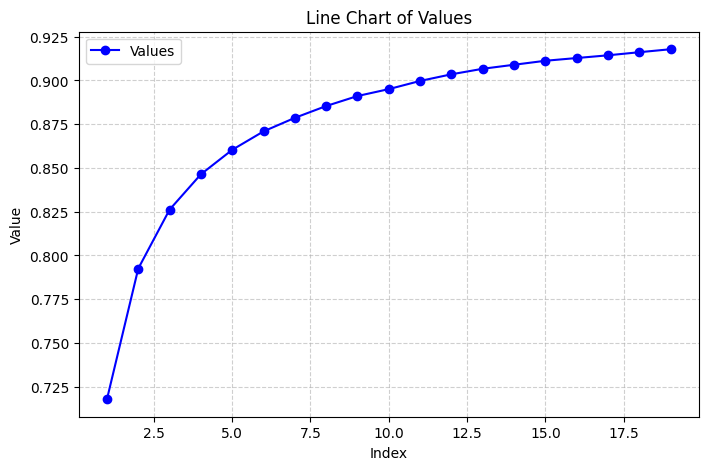

In [45]:
x = list(range(1, len(percentages) + 1))

plt.figure(figsize=(8, 5))
plt.plot(x, percentages, marker='o', linestyle='-', color='b', label='Values')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Chart of Values')

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.show()

評価データで
- Rank1 のみだと 72% のヒット
- Rank2 を含めると 79%
- Rank3 を含めると 83%
- Rank4 を含めると 85%
- Rank5 を含めると 86%